# Team 24 Group Project Proposal

Date: March 6th 2021

Authors: Kian Da Costa, Jack He, Dani Fookes, Ethan Tse


## Introduction:

For students, balancing life and school can be challenging, and achieving a balance between leisure and studying is often critical to a good academic standing. 

Here, we propose using a K nearest neighbors (KNN)-model to explore the relationship between time spent on several common distractions and grades received in school.

The dataset we will be using for this analysis was collected by Paulo Cortez from the University of Minho, GuimarÃ£es, Portugal. This dataset details the performance of students aged 15-22 from two Portugeuse secondary schools. Each row represents an observation of a single student, with the grades they received from each period (G1, G2, G3) along with various details of their life, such as how much free time they have, whether they are in a romantic relationship etc.

# Load Relevant Libraries

In [14]:
library(tidyverse)
library(tidymodels)
library(RColorBrewer)
library(repr)
set.seed(1000)

# Data Collection

In [5]:

#Idea from: https://stackoverflow.com/questions/3053833/using-r-to-download-zipped-data-file-extract-and-import-data

#Data from: https://archive.ics.uci.edu/ml/machine-learning-databases/00320/ 
#and https://archive.ics.uci.edu/ml/datasets/Student+Performance


#make a temporary file 
tempfile <- tempfile()

#download file into temp 
download.file("https://archive.ics.uci.edu/ml/machine-learning-databases/00320/student.zip", 
              tempfile) 

#extract relevant files 
student_mat <- read.table(unz(tempfile, "student-mat.csv"), 
                          header = TRUE, 
                          sep = ";")
student_por <- read.table(unz(tempfile, "student-por.csv"), 
                          header = TRUE, 
                          sep = ";")
unlink(tempfile)

#read files to see
head(student_mat, 5)
head(student_por, 5)


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,⋯,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,GP,F,18,U,GT3,A,4,4,at_home,teacher,⋯,4,3,4,1,1,3,6,5,6,6
2,GP,F,17,U,GT3,T,1,1,at_home,other,⋯,5,3,3,1,1,3,4,5,5,6
3,GP,F,15,U,LE3,T,1,1,at_home,other,⋯,4,3,2,2,3,3,10,7,8,10
4,GP,F,15,U,GT3,T,4,2,health,services,⋯,3,2,2,1,1,5,2,15,14,15
5,GP,F,16,U,GT3,T,3,3,other,other,⋯,4,3,2,1,2,5,4,6,10,10


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,⋯,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,GP,F,18,U,GT3,A,4,4,at_home,teacher,⋯,4,3,4,1,1,3,4,0,11,11
2,GP,F,17,U,GT3,T,1,1,at_home,other,⋯,5,3,3,1,1,3,2,9,11,11
3,GP,F,15,U,LE3,T,1,1,at_home,other,⋯,4,3,2,2,3,3,6,12,13,12
4,GP,F,15,U,GT3,T,4,2,health,services,⋯,3,2,2,1,1,5,0,14,14,14
5,GP,F,16,U,GT3,T,3,3,other,other,⋯,4,3,2,1,2,5,0,11,13,13


## Tidying the data/Splitting into training and testing sets
For the remaining code in this notebooks, we will be working on the __training data__ only 

Here, we merge the two datasets to include grades for both Math and Portugese

In [28]:
#Merge the datasets
total_set <- rbind(student_mat, student_por) 

#filter for desired columns
filtered_set <- total_set %>% 
                select(goout, Dalc, Walc, G3)

#split our dataset into a training and testing set.
data_split <- initial_split(filtered_set, prop = 0.75, strata = G3)  #where G3 = final grade
data_train <- training(data_split)   
data_test <- testing(data_split)
head(data_train, 4)

,goout,Dalc,Walc,G3
,<int>,<int>,<int>,<int>
1,4,1,1,6
2,3,1,1,6
4,2,1,1,15
5,2,1,2,10


# Exploratory Data Analysis: 

## Average Rate of the three predictor variables 

In [7]:
#Find the mean of our predictor variables goout, Dalc, Walc
predictor_means <- data_train %>%
                   select(goout, Dalc, Walc) %>%
                   map_df(mean)
predictor_means

goout,Dalc,Walc
<dbl>,<dbl>,<dbl>
3.173248,1.48535,2.28535


We can see that on average more people go out with their friends versus drinking alcohol on the weekdays or weekends. It will be interesting to see if this variable has a greater effect on students' grades versus alcohol consumption.

## Summarize the number of observations for each class


In [8]:
#first see if the number of observations for each class is similar, otherwise the model will not be properly trained. 
instances_for_classes <- data_train %>%  
    select(G3) %>%  
    group_by(G3) %>%  
    summarize(n = n(),
            percentage = n() / nrow(data_train) * 100)

instances_for_classes

`summarise()` ungrouping output (override with `.groups` argument)



G3,n,percentage
<int>,<int>,<dbl>
0,42,5.3503185
4,1,0.1273885
5,6,0.7643312
6,13,1.6560510
7,14,1.7834395
8,52,6.6242038
9,45,5.7324841
10,115,14.6496815
11,114,14.5222930


## Modify initial dataset: Add Classification for G3 

To correct the imbalance, we can use step_upsample (future step).

In [9]:
#reduce the number of classes our model needs to predict by grouping final grades (G3)
data_train_new_classifier <- data_train %>% 
    mutate(G3_class = case_when((G3 >= 0 & G3 <= 5) ~ "very poor", 
                                (G3 >= 6 & G3 <= 10) ~ "poor",
                                (G3 >= 11 & G3 <= 15) ~ "average", 
                                (G3 >= 16 & G3 <= 20) ~ "good"))

head(data_train_new_classifier, 10)
unique(data_train_new_classifier$G3_class)

,goout,Dalc,Walc,G3,G3_class
,<int>,<int>,<int>,<int>,<chr>
1,4,1,1,6,poor
2,3,1,1,6,poor
3,2,1,1,15,average
4,2,1,2,10,poor
5,4,1,1,11,average
6,4,1,1,6,poor
7,3,1,2,9,poor
8,2,1,1,12,average
9,3,1,3,14,average


[1] "poor"      "average"   "very poor" "good"

In [10]:
#Add summary 
summary <- data_train_new_classifier %>% 
    select(G3_class) %>% 
    group_by(G3_class) %>% 
    summarize(n = n(),
              percentage = n() / nrow(data_train) * 100)

summary
    

`summarise()` ungrouping output (override with `.groups` argument)



G3_class,n,percentage
<chr>,<int>,<dbl>
average,403,51.337580
good,94,11.974522
poor,239,30.445860
very poor,49,6.242038


## Visualization: 

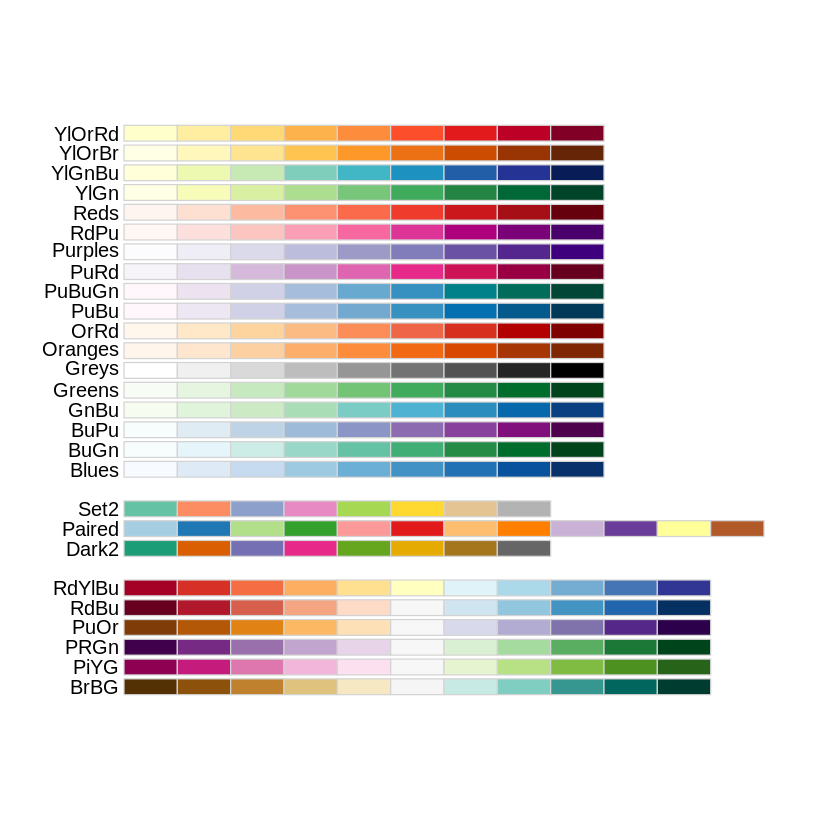

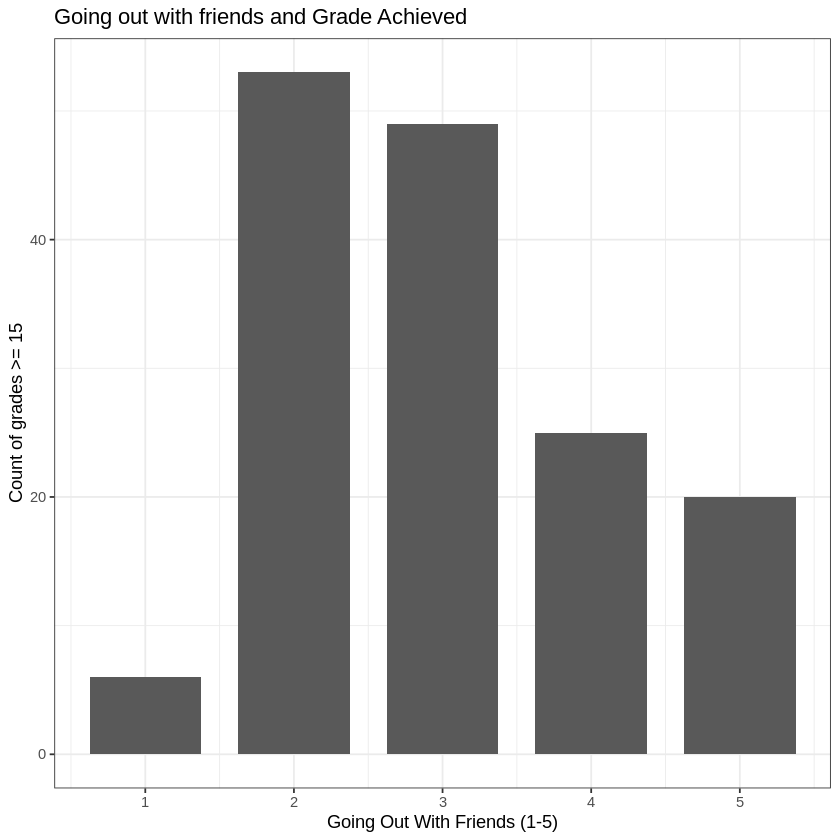

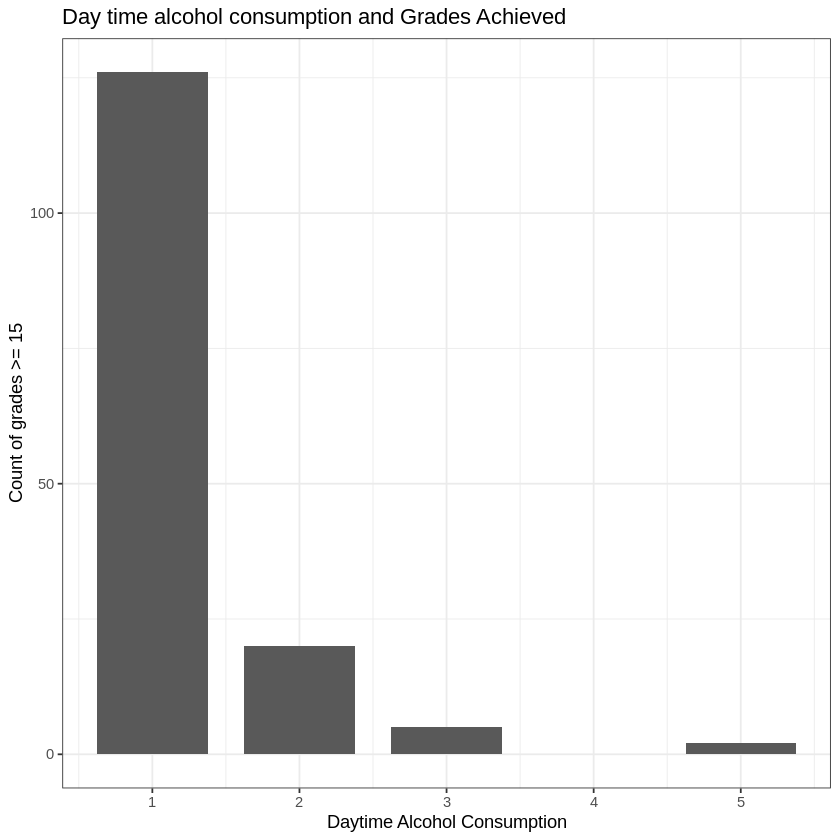

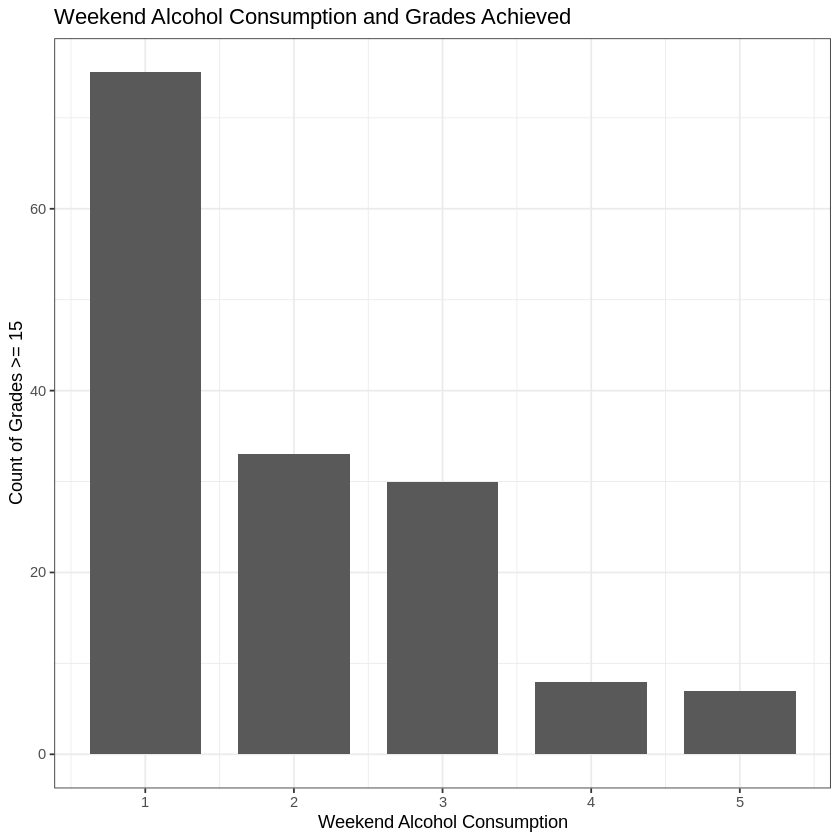

In [27]:
#plots that display the count of how many people got good grades (G3 >= 15) for each predictor variable

#Add Colour Scheme 
#View RColorBrewer possible palettes 
display.brewer.all(colorblindFriendly = T)

goout_viz <- data_train %>%
    filter(G3 >= 15) %>%
    ggplot(aes(x = goout)) +
    geom_bar(width = 0.75) +
    labs(x = "Going Out With Friends (1-5)", 
        y = "Count of grades >= 15") + 
    ggtitle("Going out with friends and Grade Achieved") + 
    theme_bw()
    
dalc_viz <- data_train %>%
    filter(G3 >= 15) %>%
    ggplot(aes(x = Dalc)) +
    geom_bar(width = 0.75) +
    labs(x = "Daytime Alcohol Consumption", 
        y = "Count of grades >= 15") + 
    ggtitle("Day time alcohol consumption and Grades Achieved") + 
    theme_bw()
walc_viz <- data_train %>%
    filter(G3 >= 15) %>%
    ggplot(aes(x = Walc)) +
    geom_bar(width = 0.75) +
    labs(x = "Weekend Alcohol Consumption", 
        y = "Count of Grades >= 15") + 
    ggtitle("Weekend Alcohol Consumption and Grades Achieved") + 
    theme_bw()
goout_viz
dalc_viz
walc_viz

We can see that there is a clear trend with alcohol consumption - students who drink more alcohol tend to not get good grades. However, the trend is not as clear with the "going out with friends" variable. 

# SEPARATOR ---------------------------------------------------------------------------------------

# Results 

## K Nearest Neighbours Classification

Here, we will use KNN Classification to 